In [4]:
# ==============================================================================
# CELLULE 1 : CONFIGURATION ET INSTALLATION
# ==============================================================================

print("🚀 CELLULE 1: Configuration initiale")
print("="*50)

# Installation des packages
!pip install -q nltk tensorflow tqdm

# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pickle
import os

print("✅ Packages installés et importés")

# Configuration GPU
print("\n🔧 Configuration GPU...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ GPU configuré: {gpus[0].name}")
    except RuntimeError as e:
        print(f"❌ Erreur GPU: {e}")
else:
    print("⚠️  Utilisation CPU")

# Montage Google Drive
print("\n💾 Montage Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

# Configuration des chemins
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/DL_Word2Vec'
DATA_PATH = f'{BASE_PATH}/Data'
MODEL_PATH = f'{BASE_PATH}/Model'

# Création des dossiers
for path in [BASE_PATH, DATA_PATH, MODEL_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"✅ Structure créée:")
print(f"   📁 Base: {BASE_PATH}")
print(f"   📊 Data: {DATA_PATH}")
print(f"   🧠 Model: {MODEL_PATH}")

# Téléchargement NLTK
print("\n📚 Configuration NLTK...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
stop_words = set(stopwords.words('english'))

print("✅ CELLULE 1 TERMINÉE - Passez à la cellule 2")


🚀 CELLULE 1: Configuration initiale
✅ Packages installés et importés

🔧 Configuration GPU...
✅ GPU configuré: /physical_device:GPU:0

💾 Montage Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Structure créée:
   📁 Base: /content/drive/MyDrive/Colab Notebooks/DL_Word2Vec
   📊 Data: /content/drive/MyDrive/Colab Notebooks/DL_Word2Vec/Data
   🧠 Model: /content/drive/MyDrive/Colab Notebooks/DL_Word2Vec/Model

📚 Configuration NLTK...
✅ CELLULE 1 TERMINÉE - Passez à la cellule 2


In [5]:
# ==============================================================================
# CELLULE 2 : CHARGEMENT DES DONNÉES
# ==============================================================================

print("🚀 CELLULE 2: Chargement des données")
print("="*50)

# Fonction de chargement robuste
def load_dataset():
    """Essaie de charger le dataset depuis différents emplacements"""
    locations = [
        f"{DATA_PATH}/MovieReview.csv",
        f"{BASE_PATH}/MovieReview.csv",
        "/content/MovieReview.csv",
        "MovieReview.csv"
    ]

    for location in locations:
        try:
            df = pd.read_csv(location)
            print(f"✅ Dataset chargé depuis: {location}")
            return df
        except FileNotFoundError:
            print(f"❌ Non trouvé: {location}")
            continue

    print("\n🛑 DATASET NON TROUVÉ!")
    print("Veuillez uploader MovieReview.csv dans Colab ou le placer dans:")
    for loc in locations:
        print(f"   - {loc}")
    return None

# Chargement des données
df = load_dataset()

if df is not None:
    print(f"\n📊 Dataset chargé avec succès!")
    print(f"   📏 Shape: {df.shape}")
    print(f"   📝 Colonnes: {list(df.columns)}")

    # Aperçu des données
    print(f"\n👀 Aperçu des 3 premières reviews:")
    for i in range(min(3, len(df))):
        review_text = str(df.review.iloc[i])[:100] + "..."
        print(f"   {i+1}. {review_text}")

    # Suppression de la colonne sentiment si elle existe
    if 'sentiment' in df.columns:
        df = df.drop('sentiment', axis=1)
        print("✅ Colonne 'sentiment' supprimée")

    # Statistiques de base
    print(f"\n📊 Statistiques:")
    print(f"   - Reviews totales: {len(df):,}")
    print(f"   - Reviews non vides: {df.review.notna().sum():,}")
    print(f"   - Longueur moyenne: {df.review.str.len().mean():.0f} caractères")
    print(f"   - Longueur min/max: {df.review.str.len().min()} / {df.review.str.len().max()}")

    print("✅ CELLULE 2 TERMINÉE - Passez à la cellule 3")
else:
    print("🛑 ARRÊT - Veuillez d'abord charger le dataset")


🚀 CELLULE 2: Chargement des données
✅ Dataset chargé depuis: /content/drive/MyDrive/Colab Notebooks/DL_Word2Vec/Data/MovieReview.csv

📊 Dataset chargé avec succès!
   📏 Shape: (25000, 2)
   📝 Colonnes: ['sentiment', 'review']

👀 Aperçu des 3 premières reviews:
   1. With all this stuff going down at the moment with MJ i've started listening to his music, watching t...
   2. 'The Classic War of the Worlds' by Timothy Hines is a very entertaining film that obviously goes to ...
   3. The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal...
✅ Colonne 'sentiment' supprimée

📊 Statistiques:
   - Reviews totales: 25,000
   - Reviews non vides: 25,000
   - Longueur moyenne: 1305 caractères
   - Longueur min/max: 52 / 13603
✅ CELLULE 2 TERMINÉE - Passez à la cellule 3


In [6]:
# ==============================================================================
# CELLULE 3 : PREPROCESSING DES TEXTES
# ==============================================================================

print("🚀 CELLULE 3: Preprocessing des textes")
print("="*50)

def preprocess_text(text):
    """Fonction de preprocessing complète"""
    if pd.isna(text) or text == '':
        return ''

    # Conversion en string et minuscules
    text = str(text).lower().strip()

    # Suppression des accents
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')

    # Espacement autour de la ponctuation
    text = re.sub(r"([?.!,¿])", r" \1 ", text)

    # Suppression des espaces multiples
    text = re.sub(r'[" "]+', " ", text)

    # Garde seulement lettres et ponctuation de base
    text = re.sub(r"[^a-zA-Z?.! ]+", " ", text)

    # Suppression des mots de 1-2 lettres
    text = re.sub(r'\b\w{1,2}\b', '', text)

    # Tokenisation et suppression des stop words
    try:
        tokens = word_tokenize(text.strip())
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        return ' '.join(tokens).strip()
    except:
        return text.strip()

# Test de la fonction sur un échantillon
print("🧪 Test de preprocessing:")
if 'df' in locals() and len(df) > 0:
    sample_text = df.review.iloc[0]
    processed = preprocess_text(sample_text)

    print(f"Original  : {str(sample_text)[:150]}...")
    print(f"Processed : {processed[:150]}...")

    # Application sur toutes les données
    print(f"\n🔄 Application sur {len(df):,} reviews...")
    tqdm.pandas(desc="Preprocessing")
    df['review_clean'] = df.review.progress_apply(preprocess_text)

    # Nettoyage - garde seulement les reviews avec plus de 10 caractères
    df_clean = df[df.review_clean.str.len() > 10].copy()

    print(f"\n📊 Résultats du preprocessing:")
    print(f"   - Reviews originales: {len(df):,}")
    print(f"   - Reviews conservées: {len(df_clean):,}")
    print(f"   - Taux de conservation: {len(df_clean)/len(df)*100:.1f}%")

    # Statistiques après preprocessing
    print(f"   - Longueur moyenne après: {df_clean.review_clean.str.len().mean():.0f} caractères")

    # Aperçu après preprocessing
    print(f"\n👀 Exemples après preprocessing:")
    for i in range(min(3, len(df_clean))):
        clean_text = df_clean.review_clean.iloc[i][:100] + "..."
        print(f"   {i+1}. {clean_text}")

    # Sauvegarde
    processed_file = f"{DATA_PATH}/preprocessed_reviews.pkl"
    df_clean.to_pickle(processed_file)
    print(f"\n💾 Données sauvegardées: {processed_file}")

    print("✅ CELLULE 3 TERMINÉE - Passez à la cellule 4")
else:
    print("🛑 ERREUR - Variable 'df' non trouvée. Exécutez d'abord la cellule 2")

🚀 CELLULE 3: Preprocessing des textes
🧪 Test de preprocessing:
Original  : With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz...
Processed : with all this stuff going down  the moment with    started listening  his music   watching the odd documentary here and there   watched the wiz and wa...

🔄 Application sur 25,000 reviews...


Preprocessing: 100%|██████████| 25000/25000 [00:24<00:00, 1040.19it/s]



📊 Résultats du preprocessing:
   - Reviews originales: 25,000
   - Reviews conservées: 25,000
   - Taux de conservation: 100.0%
   - Longueur moyenne après: 1234 caractères

👀 Exemples après preprocessing:
   1. with all this stuff going down  the moment with    started listening  his music   watching the odd d...
   2. the classic war  the worlds   timothy hines   very entertaining film that obviously goes  great effo...
   3. the film starts with  manager  nicholas bell  giving welcome investors  robert carradine   primal pa...

💾 Données sauvegardées: /content/drive/MyDrive/Colab Notebooks/DL_Word2Vec/Data/preprocessed_reviews.pkl
✅ CELLULE 3 TERMINÉE - Passez à la cellule 4


In [7]:
# ==============================================================================
# CELLULE 4 : TOKENISATION
# ==============================================================================

print("🚀 CELLULE 4: Tokenisation")
print("="*50)

if 'df_clean' not in locals():
    print("🛑 ERREUR - Variable 'df_clean' non trouvée. Exécutez d'abord la cellule 3")
else:
    # Configuration du tokenizer
    MAX_WORDS = 10000
    print(f"📝 Configuration tokenizer:")
    print(f"   - Vocabulaire maximum: {MAX_WORDS:,} mots")
    print(f"   - Token OOV: <OOV>")

    # Création et entraînement du tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=MAX_WORDS,
        oov_token="<OOV>",
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    )

    print(f"\n🔄 Entraînement sur {len(df_clean):,} reviews...")
    tokenizer.fit_on_texts(df_clean.review_clean)

    # Statistiques du vocabulaire
    vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)
    print(f"✅ Tokenizer créé!")
    print(f"   - Mots uniques trouvés: {len(tokenizer.word_index):,}")
    print(f"   - Vocabulaire final: {vocab_size:,} mots")

    # Top 20 des mots les plus fréquents
    print(f"\n📊 Top 20 des mots les plus fréquents:")
    word_freq = tokenizer.word_counts
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]

    for i, (word, freq) in enumerate(top_words, 1):
        print(f"   {i:2d}. {word:<15} : {freq:,}")

    # Test de conversion
    print(f"\n🧪 Test de conversion:")
    test_sentence = df_clean.review_clean.iloc[0]
    test_sequence = tokenizer.texts_to_sequences([test_sentence])[0]

    print(f"Texte original: {test_sentence[:100]}...")
    print(f"Séquence (10 premiers IDs): {test_sequence[:10]}")

    # Conversion inverse pour vérification
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    decoded = [reverse_word_index.get(id, '<UNK>') for id in test_sequence[:10]]
    print(f"Mots décodés: {decoded}")

    # Sauvegarde du tokenizer
    tokenizer_file = f"{DATA_PATH}/tokenizer.pkl"
    with open(tokenizer_file, 'wb') as f:
        pickle.dump(tokenizer, f)

    print(f"\n💾 Tokenizer sauvegardé: {tokenizer_file}")
    print("✅ CELLULE 4 TERMINÉE - Passez à la cellule 5")


🚀 CELLULE 4: Tokenisation
📝 Configuration tokenizer:
   - Vocabulaire maximum: 10,000 mots
   - Token OOV: <OOV>

🔄 Entraînement sur 25,000 reviews...
✅ Tokenizer créé!
   - Mots uniques trouvés: 72,662
   - Vocabulaire final: 10,000 mots

📊 Top 20 des mots les plus fréquents:
    1. the             : 336,758
    2. and             : 164,144
    3. this            : 76,007
    4. that            : 73,287
    5. was             : 48,209
    6. for             : 44,346
    7. with            : 44,130
    8. movie           : 44,047
    9. but             : 42,623
   10. film            : 40,162
   11. you             : 34,268
   12. not             : 30,634
   13. are             : 29,438
   14. his             : 29,376
   15. have            : 27,732
   16. one             : 26,795
   17. all             : 23,985
   18. they            : 22,916
   19. who             : 21,442
   20. from            : 20,499

🧪 Test de conversion:
Texte original: with all this stuff going down  the momen

In [8]:
# ==============================================================================
# CELLULE 5 : GÉNÉRATION DES DONNÉES SKIP-GRAM
# ==============================================================================

print("🚀 CELLULE 5: Génération des données Skip-gram")
print("="*50)

if 'tokenizer' not in locals() or 'df_clean' not in locals():
    print("🛑 ERREUR - Variables manquantes. Exécutez d'abord les cellules précédentes")
else:

    def create_skipgram_pairs(tokens, window_size=2):
        """Crée les paires (mot_centre, mot_contexte) pour Skip-gram"""
        if len(tokens) <= window_size * 2:
            return [], []

        center_words = []
        context_words = []

        for i in range(window_size, len(tokens) - window_size):
            center_word = tokens[i]

            # Collecte tous les mots contexte dans la fenêtre
            for j in range(i - window_size, i + window_size + 1):
                if j != i:  # Exclure le mot centre lui-même
                    context_words.append(tokens[j])
                    center_words.append(center_word)

        return center_words, context_words

    # Configuration
    WINDOW_SIZE = 2
    MAX_PAIRS = 500000  # Limite pour éviter surcharge mémoire

    print(f"⚙️  Configuration:")
    print(f"   - Taille de fenêtre: {WINDOW_SIZE}")
    print(f"   - Limite de paires: {MAX_PAIRS:,}")

    # Génération des paires d'entraînement
    print(f"\n🔄 Génération des paires sur {len(df_clean):,} reviews...")

    X, y = [], []
    total_pairs = 0
    processed_reviews = 0

    for idx, review in enumerate(tqdm(df_clean.review_clean, desc="Génération")):
        # Conversion en séquence d'entiers
        sequences = tokenizer.texts_to_sequences([review])

        if len(sequences) > 0 and len(sequences[0]) > WINDOW_SIZE * 2:
            tokens = sequences[0]

            # Génération des paires skip-gram
            centers, contexts = create_skipgram_pairs(tokens, WINDOW_SIZE)

            X.extend(centers)
            y.extend(contexts)
            total_pairs += len(centers)
            processed_reviews += 1

        # Arrêt si limite atteinte
        if total_pairs >= MAX_PAIRS:
            print(f"\n⚠️  Limite de {MAX_PAIRS:,} paires atteinte")
            break

    # Conversion en arrays numpy
    X = np.array(X, dtype=np.int32)
    y = np.array(y, dtype=np.int32)

    print(f"\n✅ Génération terminée!")
    print(f"📊 Statistiques:")
    print(f"   - Reviews traitées: {processed_reviews:,}")
    print(f"   - Paires générées: {len(X):,}")
    print(f"   - Shape X (centres): {X.shape}")
    print(f"   - Shape y (contextes): {y.shape}")
    print(f"   - Mémoire utilisée: {(X.nbytes + y.nbytes) / 1024 / 1024:.1f} MB")

    # Affichage d'exemples (CORRIGÉ)
    print(f"\n🔍 Exemples de paires (mot_centre -> mot_contexte):")
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

    for i in range(min(10, len(X))):
        center_id = X[i]
        context_id = y[i]

        center_word = reverse_word_index.get(center_id, f"UNK_{center_id}")
        context_word = reverse_word_index.get(context_id, f"UNK_{context_id}")

        print(f"   {i+1:2d}. {center_word:<15} -> {context_word}")

    # Statistiques des IDs
    print(f"\n📈 Statistiques des IDs:")
    print(f"   - ID min centres: {X.min()}, max: {X.max()}")
    print(f"   - ID min contextes: {y.min()}, max: {y.max()}")
    print(f"   - Vocabulaire attendu: 1 à {vocab_size-1}")

    # Sauvegarde des données d'entraînement
    training_file = f"{DATA_PATH}/training_data.npz"
    np.savez_compressed(
        training_file,
        X=X,
        y=y,
        vocab_size=vocab_size,
        window_size=WINDOW_SIZE,
        total_pairs=len(X)
    )

    print(f"\n💾 Données sauvegardées: {training_file}")
    file_size = os.path.getsize(training_file) / 1024 / 1024
    print(f"   Taille du fichier: {file_size:.1f} MB")

    print("✅ CELLULE 5 TERMINÉE - Passez à la cellule 6")

🚀 CELLULE 5: Génération des données Skip-gram
⚙️  Configuration:
   - Taille de fenêtre: 2
   - Limite de paires: 500,000

🔄 Génération des paires sur 25,000 reviews...


Génération:   3%|▎         | 697/25000 [00:00<00:04, 4903.88it/s]


⚠️  Limite de 500,000 paires atteinte

✅ Génération terminée!
📊 Statistiques:
   - Reviews traitées: 698
   - Paires générées: 500,024
   - Shape X (centres): (500024,)
   - Shape y (contextes): (500024,)
   - Mémoire utilisée: 3.8 MB

🔍 Exemples de paires (mot_centre -> mot_contexte):
    1. this            -> with
    2. this            -> all
    3. this            -> stuff
    4. this            -> going
    5. stuff           -> all
    6. stuff           -> this
    7. stuff           -> going
    8. stuff           -> down
    9. going           -> this
   10. going           -> stuff

📈 Statistiques des IDs:
   - ID min centres: 1, max: 9922
   - ID min contextes: 1, max: 9922
   - Vocabulaire attendu: 1 à 9999



💾 Données sauvegardées: /content/drive/MyDrive/Colab Notebooks/DL_Word2Vec/Data/training_data.npz
   Taille du fichier: 0.7 MB
✅ CELLULE 5 TERMINÉE - Passez à la cellule 6


In [10]:
# ==============================================================================
# CELLULE 6 : CRÉATION DU MODÈLE WORD2VEC
# ==============================================================================

print("🚀 CELLULE 6: Création du modèle Word2Vec")
print("="*50)

if 'X' not in locals() or 'vocab_size' not in locals():
    print("🛑 ERREUR - Données d'entraînement manquantes. Exécutez d'abord la cellule 5")
else:

    # Configuration du modèle
    EMBEDDING_DIM = 100  # Dimension des vecteurs word2vec

    print(f"⚙️  Configuration du modèle:")
    print(f"   - Taille du vocabulaire: {vocab_size:,}")
    print(f"   - Dimension des embeddings: {EMBEDDING_DIM}")
    print(f"   - Architecture: Skip-gram avec Softmax")

    # Création du modèle Skip-gram
    def create_skipgram_model(vocab_size, embedding_dim):
        """Crée un modèle Word2Vec Skip-gram"""

        model = tf.keras.Sequential([
            # Couche d'embedding - c'est ici que sont stockés les vecteurs word2vec
            tf.keras.layers.Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                input_length=1,
                name='word_embedding'
            ),
            # Aplatit les embeddings
            tf.keras.layers.Flatten(),
            # Couche de sortie pour prédire le mot contexte
            tf.keras.layers.Dense(vocab_size, activation='softmax', name='context_prediction')
        ])

        return model

    # Création du modèle avec optimisation GPU/CPU
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    print(f"   - Device utilisé: {device}")

    with tf.device(device):
        model = create_skipgram_model(vocab_size, EMBEDDING_DIM)

    # Compilation du modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n🏗️  Architecture du modèle:")
    model.summary()

    # Statistiques du modèle
    model.build(input_shape=(None, 1))
    total_params = model.count_params()
    embedding_params = vocab_size * EMBEDDING_DIM
    output_params = EMBEDDING_DIM * vocab_size + vocab_size

    print(f"\n📊 Paramètres du modèle:")
    print(f"   - Paramètres totaux: {total_params:,}")
    print(f"   - Paramètres embedding: {embedding_params:,}")
    print(f"   - Paramètres sortie: {output_params:,}")
    print(f"   - Taille estimée: {total_params * 4 / 1024 / 1024:.1f} MB")

    # Forme des données d'entraînement
    print(f"\n📏 Vérification des données:")
    print(f"   - X (mots centres): {X.shape}")
    print(f"   - y (mots contextes): {y.shape}")
    print(f"   - Exemple X[0]: {X[0]} -> y[0]: {y[0]}")

    # Test rapide de prédiction (avant entraînement)
    print(f"\n🧪 Test de prédiction (avant entraînement):")
    test_input = X[:5]
    test_pred = model.predict(test_input, verbose=0)
    print(f"   - Input shape: {test_input.shape}")
    print(f"   - Output shape: {test_pred.shape}")
    print(f"   - Somme des probabilités (doit être ≈ 1.0): {test_pred[0].sum():.3f}")

    print("✅ CELLULE 6 TERMINÉE - Modèle créé et prêt pour l'entraînement")
    print("➡️  Passez à la cellule 7 pour le test rapide")

🚀 CELLULE 6: Création du modèle Word2Vec
⚙️  Configuration du modèle:
   - Taille du vocabulaire: 10,000
   - Dimension des embeddings: 100
   - Architecture: Skip-gram avec Softmax
   - Device utilisé: /GPU:0

🏗️  Architecture du modèle:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word_embedding (Embedding)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ context_prediction (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


📊 Paramètres du modèle:
   - Paramètres totaux: 2,010,000
   - Paramètres embedding: 1,000,000
   - Paramètres sortie: 1,010,000
   - Taille estimée: 7.7 MB

📏 Vérification des données:
   - X (mots centres): (500024,)
   - y (mots contextes): (500024,)
   - Exemple X[0]: 4 -> y[0]: 8

🧪 Test de prédiction (avant entraînement):
   - Input shape: (5,)
   - Output shape: (5, 10000)
   - Somme des probabilités (doit être ≈ 1.0): 1.000
✅ CELLULE 6 TERMINÉE - Modèle créé et prêt pour l'entraînement
➡️  Passez à la cellule 7 pour le test rapide


🚀 CELLULE 7: Test rapide du modèle
🧪 Configuration du test:
   - Échantillons: 10,000 / 500,024
   - Époques: 3
   - Batch size: 256
   - Validation split: 10%

🚀 Lancement du test rapide...
Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.0508 - loss: 8.7952 - val_accuracy: 0.0540 - val_loss: 8.4180
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0900 - loss: 6.1694 - val_accuracy: 0.0630 - val_loss: 8.5984
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1049 - loss: 5.5955 - val_accuracy: 0.0650 - val_loss: 8.7243

📊 Résultats du test:
   ⏱️  Durée: 6.3 secondes
   📈 Accuracy finale: 0.1033
   📉 Loss finale: 5.5832
   📈 Val Accuracy: 0.0650
   📉 Val Loss: 8.7243

⏰ Estimations pour l'entraînement complet:
   - Vitesse: 4,762 échantillons/seconde
   - Pour 20 époques sur 500,024 échantillons:
   - Temps estimé: 35.0 minutes
   - Temps estimé: 0.58 heures

🔍 Test des embeddings après 3 époques:
   - Shape des embeddings: (10000, 100)
   - Mo

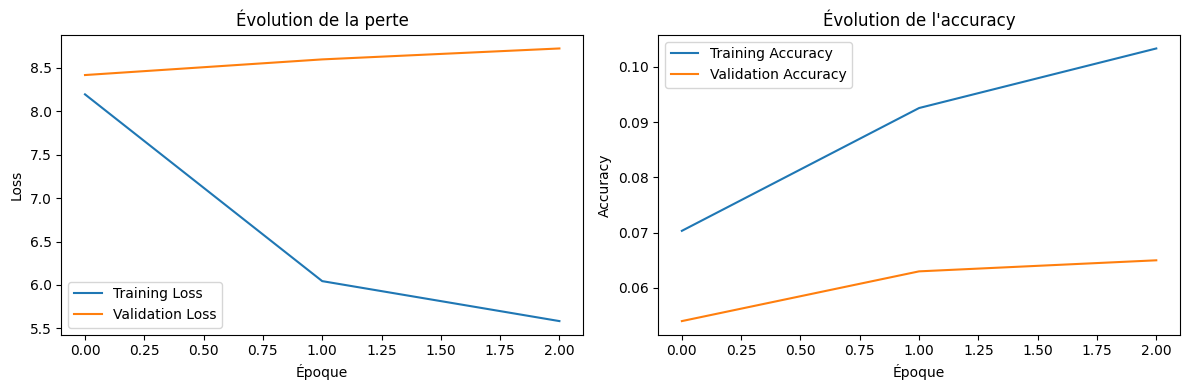

✅ CELLULE 7 TERMINÉE - Test rapide effectué
➡️  Vous pouvez passer à l'entraînement complet ou explorer les embeddings


In [12]:
# ==============================================================================
# CELLULE 7 : TEST RAPIDE DU MODÈLE
# ==============================================================================

print("🚀 CELLULE 7: Test rapide du modèle")
print("="*50)

if 'model' not in locals() or 'X' not in locals():
    print("🛑 ERREUR - Modèle ou données manquants. Exécutez les cellules précédentes")
else:

    # Configuration du test
    TEST_SIZE = 10000  # Nombre d'échantillons pour le test
    TEST_EPOCHS = 3    # Nombre d'époques pour le test
    BATCH_SIZE = 256

    # Préparation des données de test
    test_size = min(TEST_SIZE, len(X))
    X_test = X[:test_size]
    y_test = y[:test_size]

    print(f"🧪 Configuration du test:")
    print(f"   - Échantillons: {test_size:,} / {len(X):,}")
    print(f"   - Époques: {TEST_EPOCHS}")
    print(f"   - Batch size: {BATCH_SIZE}")
    print(f"   - Validation split: 10%")

    # Lancement du test
    print(f"\n🚀 Lancement du test rapide...")
    start_time = time.time()

    # Entraînement de test
    test_history = model.fit(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        epochs=TEST_EPOCHS,
        validation_split=0.1,
        verbose=1,
        shuffle=True
    )

    test_duration = time.time() - start_time

    # Résultats du test
    print(f"\n📊 Résultats du test:")
    print(f"   ⏱️  Durée: {test_duration:.1f} secondes")
    print(f"   📈 Accuracy finale: {test_history.history['accuracy'][-1]:.4f}")
    print(f"   📉 Loss finale: {test_history.history['loss'][-1]:.4f}")

    if 'val_accuracy' in test_history.history:
        print(f"   📈 Val Accuracy: {test_history.history['val_accuracy'][-1]:.4f}")
        print(f"   📉 Val Loss: {test_history.history['val_loss'][-1]:.4f}")

    # Estimations pour l'entraînement complet
    FULL_EPOCHS = 20
    samples_per_second = test_size / test_duration * TEST_EPOCHS
    estimated_full_time = (len(X) * FULL_EPOCHS) / samples_per_second

    print(f"\n⏰ Estimations pour l'entraînement complet:")
    print(f"   - Vitesse: {samples_per_second:,.0f} échantillons/seconde")
    print(f"   - Pour {FULL_EPOCHS} époques sur {len(X):,} échantillons:")
    print(f"   - Temps estimé: {estimated_full_time/60:.1f} minutes")
    print(f"   - Temps estimé: {estimated_full_time/3600:.2f} heures")

    # Test de similarité basique
    print(f"\n🔍 Test des embeddings après {TEST_EPOCHS} époques:")

    # Extraction des embeddings
    embeddings = model.get_layer('word_embedding').get_weights()[0]
    print(f"   - Shape des embeddings: {embeddings.shape}")

    # Test sur quelques mots fréquents
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    test_words = []

    # Trouve quelques mots fréquents pour le test
    for word_id in range(1, min(100, len(reverse_word_index))):
        if word_id in reverse_word_index:
            word = reverse_word_index[word_id]
            if len(word) > 3:  # Mots de plus de 3 lettres
                test_words.append((word, word_id))
            if len(test_words) >= 5:
                break

    print(f"   - Mots testés: {[word for word, _ in test_words]}")

    # Calcul de similarités basiques
    if test_words:
        word1, id1 = test_words[0]
        vec1 = embeddings[id1]

        print(f"   - Vecteur '{word1}' (5 premiers): {vec1[:5]}")
        print(f"   - Norme du vecteur: {np.linalg.norm(vec1):.3f}")

    # Graphique de l'évolution (si matplotlib disponible)
    try:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(test_history.history['loss'], label='Training Loss')
        plt.plot(test_history.history['val_loss'], label='Validation Loss')
        plt.title('Évolution de la perte')
        plt.xlabel('Époque')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(test_history.history['accuracy'], label='Training Accuracy')
        plt.plot(test_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title("Évolution de l'accuracy")
        plt.xlabel('Époque')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Erreur lors de l'affichage des graphiques: {e}")

    print("✅ CELLULE 7 TERMINÉE - Test rapide effectué")
    print("➡️  Vous pouvez passer à l'entraînement complet ou explorer les embeddings")


🚀 CELLULE 8: Entraînement complet du modèle Word2Vec
⚙️  Paramètres d'entraînement:
   - Époques: 50
   - Batch size: 128
   - Échantillons: 500,024
   - Validation split: 10%
Epoch 1/50
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.0671 - loss: 6.3157 - val_accuracy: 0.0678 - val_loss: 7.2796
Epoch 2/50
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.0714 - loss: 6.1900 - val_accuracy: 0.0677 - val_loss: 7.2712
Epoch 3/50
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.0712 - loss: 6.1924 - val_accuracy: 0.0722 - val_loss: 7.2724
Epoch 4/50
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.0724 - loss: 6.1865 - val_accuracy: 0.0715 - val_loss: 7.2780
Epoch 5/50
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.0729 - loss: 6.1789 - val_accuracy: 0.0716 - val_loss: 7.2849
Epoch 6/50
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.0727 - loss: 6.1828 - val_accuracy: 0.0722 - val_loss: 7.3298
Epoch 7/50
3516/3516 ━━━━━━━━━━━━━━━━━

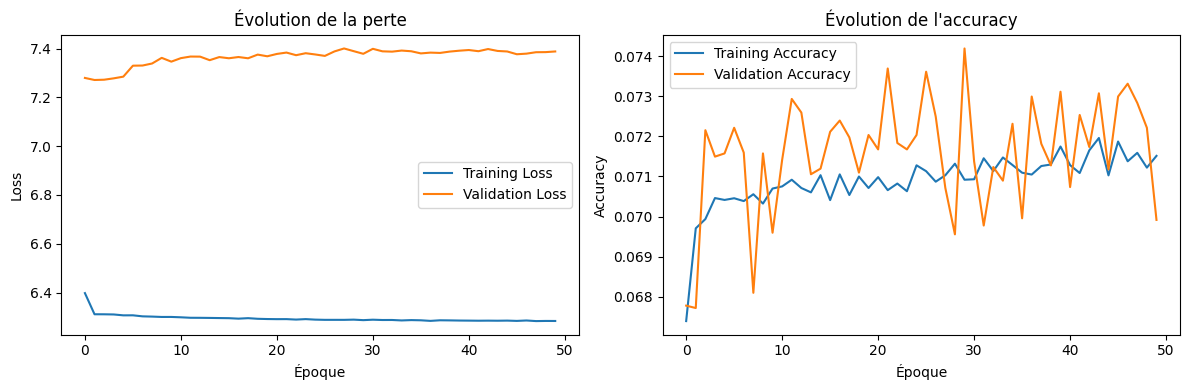

📦 Le modèle est maintenant prêt à être utilisé pour des tests, visualisations ou exports.


In [14]:
# ==============================================================================
# CELLULE 8 : ENTRAÎNEMENT COMPLET DU MODÈLE WORD2VEC
# ==============================================================================

print("🚀 CELLULE 8: Entraînement complet du modèle Word2Vec")
print("="*50)

if 'model' not in locals() or 'X' not in locals():
    print("🛑 ERREUR - Modèle ou données manquants. Exécutez les cellules précédentes")
else:
    # Configuration
    FULL_EPOCHS = 50       # Nombre d'époques complètes
    BATCH_SIZE = 128       # Batch size (augmentez si vous avez plus de VRAM)
    VALIDATION_SPLIT = 0.1 # Validation automatique

    print(f"⚙️  Paramètres d'entraînement:")
    print(f"   - Époques: {FULL_EPOCHS}")
    print(f"   - Batch size: {BATCH_SIZE}")
    print(f"   - Échantillons: {len(X):,}")
    print(f"   - Validation split: {VALIDATION_SPLIT * 100:.0f}%")

    # Entraînement complet
    start_time = time.time()
    full_history = model.fit(
        X, y,
        batch_size=BATCH_SIZE,
        epochs=FULL_EPOCHS,
        validation_split=VALIDATION_SPLIT,
        shuffle=True,
        verbose=1
    )
    duration = time.time() - start_time

    print(f"\n✅ Entraînement terminé en {duration/60:.1f} minutes")

    # Graphiques d'évolution
    try:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(full_history.history['loss'], label='Training Loss')
        plt.plot(full_history.history['val_loss'], label='Validation Loss')
        plt.title("Évolution de la perte")
        plt.xlabel("Époque")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(full_history.history['accuracy'], label='Training Accuracy')
        plt.plot(full_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title("Évolution de l'accuracy")
        plt.xlabel("Époque")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Erreur lors de l'affichage des graphiques: {e}")

    print("📦 Le modèle est maintenant prêt à être utilisé pour des tests, visualisations ou exports.")


In [15]:
model.save('/content/drive/MyDrive/Colab Notebooks/DL_Word2Vec/Model/word2vec.h5')